<h2> Inverse Reinforcement Learning </h2>

In [12]:
import sys
sys.path.append('/anaconda3/lib/python3.6/site-packages')


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from IPython.display import display
from IPython.core.display import HTML

In [14]:
def multi_table(table_list):
    """
    Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    """ 
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [15]:
def trans_probab(current_state, next_state, action):
    act_value = [-1, -10, 1, 10]
    column = int(current_state/10)
    row = int(current_state%10)
    not_allowed = []
    if row==0:
        not_allowed.append(0) # top
    elif row==9:
        not_allowed.append(2) # bottom
    if column==0:
        not_allowed.append(1) # left
    elif column==9:
        not_allowed.append(3) # right
    
    value_action = act_value[action]
    neighbours = []
    for idx in np.arange(0,4):
        if idx not in not_allowed:
            neighbours.append(current_state + act_value[idx])
    if not_allowed: # not empty => edges or corners
        if len(not_allowed)==2: 
            if action in not_allowed:
                if next_state==current_state: # => same_state
                    return 1-w+w/4+w/4
                elif next_state in neighbours: # neighboring valid states
                    return w/4
            else: # action to stay in the grid
                if next_state==current_state: # => same_state
                    return w/4+w/4
                elif next_state==current_state+value_action and next_state in neighbours: # intended state
                    return 1-w+w/4
                elif next_state in neighbours: 
                    return w/4      
        else: # edges
            if action in not_allowed: 
                if next_state==current_state: 
                    return 1-w+w/4
                elif next_state in neighbours: 
                    return w/4
            else: # action to stay in the grid
                if next_state==current_state:
                    return w/4
                elif next_state==current_state+value_action and next_state in neighbours: # intended state
                    return 1-w+w/4
                elif next_state in neighbours: 
                    return w/4
            
    else: # non boundary
        if next_state==current_state + value_action and next_state in neighbours:
            return 1-w+w/4
        elif next_state in neighbours:
            return w/4
    return 0

def find_neighbours(current_state):
    column = int(current_state/10)
    row = int(current_state%10)
    act_value = [-1, -10, 1, 10] 
    not_allowed = [] # not_allowed directions for a given state
    if row==0:
        not_allowed.append(0) 
    elif row==9:
        not_allowed.append(2) 
    if column==0:
        not_allowed.append(1) 
    elif column==9:
        not_allowed.append(3)
    
    neighbours = []
    for idx in np.arange(0,4): # building neighbours of the current state
        if idx not in not_allowed:
            neighbours.append(current_state + act_value[idx])
    return neighbours


def value_iteration_value(reward, state_space, action_set, discount_factor):
    epsilon = 0.01
    V = np.zeros(shape=[10,10])
    delta = float("inf")
    flatten_state = []
    for element in state_space:
        for el in element:
            flatten_state.append(el)
            
    maximum = -1*float("inf")
    while delta > epsilon:
        delta = 0 
        for curr_state in flatten_state:
            curr_col = int(curr_state/10)
            curr_row = int(curr_state%10)
            v = V[curr_row][curr_col]
            neighborhood = find_neighbours(curr_state)
            states_to_visit = neighborhood + [curr_state]
            maximum = -1*float("inf")
            for action in action_set:
                total = 0
                for next_state in states_to_visit:
                    p = trans_probab(curr_state, next_state, action)
                    next_col = int(next_state/10)
                    next_row = int(next_state%10)
                    total += p * (reward[next_row, next_col] + discount_factor * V[next_row][next_col])
#                     if curr_row==9 and curr_col==9:
#                         print next_state, next_row, next_col
#                         print action, next_state, p, reward[next_row, next_col], V[next_row][next_col] 
                if total>maximum:
                    maximum = total
            V[curr_row][curr_col] = maximum
#             if curr_row==9 and curr_col==9:
#                 print ("currrow, currcol, max: ", curr_row, curr_col, maximum)
#             print ("currrow, currcol, max: ", curr_row, curr_col, maximum)
            delta = max(delta, np.abs(v - V[curr_row][curr_col]))
    return V


def val_iteration_fn(reward, state_space, action_set, discount):
    epsilon = 0.01
    V = np.zeros(shape=[10,10])
    pi = np.zeros(shape=[10,10])
    delta = float("inf")
    flat_state = []
    for element in state_space:
        for el in element:
            flat_state.append(el)
            
    maximum = -1*float("inf")
    while delta > epsilon:
        delta = 0
        temp=np.zeros([10,10])
        for current_state in flat_state:
            current_column = int(current_state/10)
            current_row = int(current_state%10)
            v = V[current_row][current_column]
            neighbours = find_neighbours(current_state)
            states_to_visit = neighbours + [current_state]
            maximum = -1*float("inf")
            for action in action_set:
                total = 0
                for next_state in states_to_visit:
                    p = trans_probab(current_state, next_state, action)
                    next_col = int(next_state/10)
                    next_row = int(next_state%10)
                    total += p * (reward[next_row, next_col] + discount * V[next_row][next_col])
                if total>maximum:
                    maximum = total
            temp[current_row][current_column] = maximum
            delta = max(delta, np.abs(v - temp[current_row][current_column]))
        V=temp
    maximum = -1*float("inf")
    for current_state in flat_state:
        current_column = int(current_state/10)
        current_row = int(current_state%10)
        neighbours = find_neighbours(current_state)
        states_to_visit = neighbours + [current_state]
        maximum = -1*float("inf")
        for action in [0,1,3,2]: # or action set
            total = 0
            for next_state in states_to_visit:
                p = trans_probab(current_state, next_state, action)
                next_col = int(next_state/10)
                next_row = int(next_state%10)
                total += p * ((reward[next_row, next_col]) + discount * V[next_row][next_col])
            if total>maximum:
                maximum = total
                max_index = action
        pi[current_row][current_column] = max_index
    return pi

In [16]:
state_num=100
action_num=4
state_space = np.zeros(shape=[10,10])
state_space = [[10.0*i+j for i in range(0,10)] for j in range(0, 10)]
action_set = [0, 1, 2, 3] # top, left, bottom, right
discount = 0.8
w=0.1

In [17]:
probability_matrix = np.zeros(shape=[100,100,4])
#probability_matrix=[[[trans_probab(i,j,k) for i in range(0,100)] for j in range(0, 100)] for k in range(0,4)] 
for k in range(0,4):
    for j in range(0,100):
        for i in range(0,100):
            probability_matrix[i][j][k]=trans_probab(i,j,k);


np.shape(probability_matrix)

(100, 100, 4)

In [18]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

def irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, lambd):
    
    c = np.zeros(3 * state_num)
    c[state_num:2 * state_num] = -1
    c[2 * state_num:3 * state_num ] = lambd
    
    h = np.zeros(2 * state_num * (action_num - 1) + 4 * state_num)
    h[2 * state_num * (action_num - 1) + 2 * state_num:2 * state_num * (action_num - 1) + 4 * state_num ]=Rmax
    
    G = np.zeros([2 * state_num * (action_num - 1) + 4 * state_num, 3 * state_num])
    
    for i in range(state_num):
        G[2 * state_num * (action_num - 1) + 2 * state_num+i,i ]=1 #800-900
        G[2 * state_num * (action_num - 1) + 3 * state_num+i,i ]=-1 #900-1000
        G[2 * state_num * (action_num - 1) + i , i ]=1 #600-700, 1st column
        G[2 * state_num * (action_num - 1) + i , 2 * state_num+i ]=-1 #600-700, 3rd column
        G[2 * state_num * (action_num - 1) + state_num+i,i ]=-1 #700-800, 1st column
        G[2 * state_num * (action_num - 1) +state_num+ i,2 * state_num+i ]=-1 #700-800, 3rd column
    
#     for i in range(state_num):            
#         G[i, state_num + i] = 1
#         G[state_num+i,state_num + i]=1
#         G[2*state_num+i,state_num + i]=1
    
    for i in range(state_num):         
        #print(type(i))
        #print(i//10)
        a_i = int(optimum_policy[i%10][i//10])
        second_term = np.linalg.inv(np.identity(state_num) - discount * probability_matrix[:,:,a_i])

        count = 0
        for a in range(action_num):
            if (a != a_i):
                G[i * (action_num - 1) + count, :state_num] = - np.dot(np.asarray(probability_matrix[i,:,a_i]) - np.asarray(probability_matrix[i,:,a]), second_term)
            
                G[state_num * (action_num - 1) + i * (action_num - 1) + count, :state_num] = - \
                np.dot(np.asarray(probability_matrix[i,:,a_i]) - np.asarray(probability_matrix[i,:,a]), second_term)
                
                G[i * (action_num - 1) + count, state_num + i] = 1
                #G[state_num * (action_num - 1) + i * (action_num - 1) + count,state_num + i] = 1
                count += 1
            
    sol = solvers.lp(matrix(c), matrix(G), matrix(h));
    return sol

In [19]:
import matplotlib.pyplot as plt
x_plot=[]
reward_1 = np.zeros(shape=[10,10])
reward_1[9][9] = 1
actual_policy=val_iteration_fn(reward_1, state_space, action_set, discount)
optimum_policy=actual_policy
Rmax=1

In [20]:
max_accuracy=0
max_lambda=0
max_reward=[]
for i in range(0,500):
    x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, i/100.0)
    current_reward=x['x'][:state_num]
    current_reward=np.reshape(current_reward,(10,10))
    current_reward=np.transpose(current_reward)
    policy_computed = val_iteration_fn(current_reward, state_space, action_set, discount)
    count =0;
    for j in range(10):
        for k in range(10):
            if(policy_computed[j][k]==actual_policy[j][k]):
                count+=1;
    accuracy=count/100.0;
    if(accuracy>max_accuracy):
        max_accuracy=accuracy
        max_lambda=i/100.0
        max_reward=current_reward
        
    x_plot.append(accuracy)

<h2> Question 11 </h2>

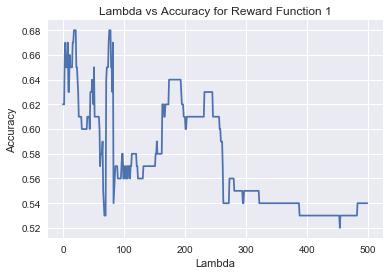

In [21]:
plt.plot(x_plot)
plt.title("Lambda vs Accuracy for Reward Function 1")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

<h2> Question 12 </h2>

In [22]:
print("max accuracy is:")
print(max_accuracy)
print("best lambda is:")
print(max_lambda)

max accuracy is:
0.68
best lambda is:
0.18


<h2> Question 13 </h2>


Heat Map - Reward Function 1


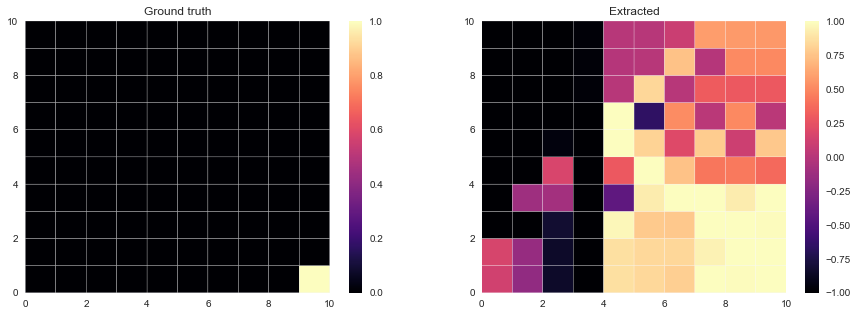

0.68


In [23]:
Rmax=1

# x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, 0.09)
# current_reward=x['x'][:state_num]
# current_reward=np.reshape(current_reward,(10,10))
# current_reward=np.transpose(current_reward)
# print(sns.heatmap(reward_1))
# print(sns.heatmap(current_reward))


print("\nHeat Map - Reward Function 1")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(reward_1), edgecolors = 'white', cmap = 'magma')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
plt.pcolor(np.flipud(max_reward), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()

policy_computed = val_iteration_fn(max_reward, state_space, action_set, discount)
count =0;
for i in range(10):
    for j in range(10):
        if(policy_computed[i][j]==actual_policy[i][j]):
            count+=1;
accuracy=count/100.0;
print(accuracy)

<h2> Question 14 </h2>

Heat map of Optimal State Values for Reward Function 1


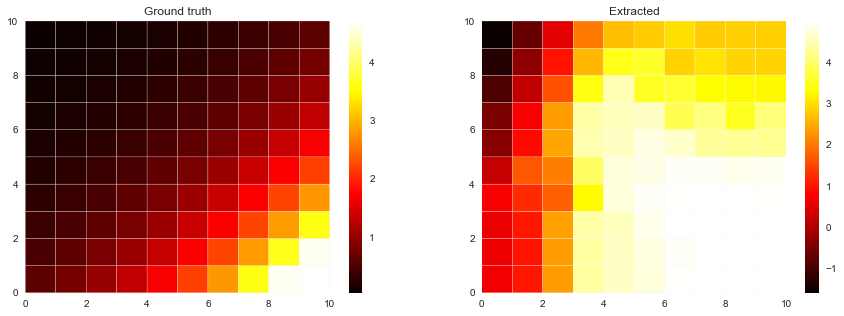

In [24]:
actual_value = value_iteration_value(reward_1, state_space, action_set, discount)
policy_value = value_iteration_value(max_reward, state_space, action_set, discount)

print("Heat map of Optimal State Values for Reward Function 1")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(actual_value), edgecolors = 'white', cmap = 'hot')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
#optimal_state_values_extracted_r1 = get_optimal_state_value_fn(extracted_reward_fn_1, S, A, gamma, 0.01, state_space, w)
plt.pcolor(np.flipud(policy_value), edgecolors = 'white', cmap = 'hot')
plt.colorbar()
plt.show()

<h2> Question 16 </h2>

In [25]:
print("Optimal policy - Ground truth vs Extracted - Reward Function 1")


from matplotlib.colors import ListedColormap

import sys
arrows = [u'\u2191', u'\u2190',u'\u2193',u'\u2192']
arrow_matrix = np.array(policy_computed, dtype=object)
# print arrows
for i in range(0, 10):
    for j in range(0, 10):
        index = int(policy_computed[i][j])
        arrow_matrix[i][j] = arrows[index]

        

arrow1_matrix = np.array(actual_policy, dtype=object)
# print arrows
for i in range(0, 10):
    for j in range(0, 10):
        index = int(actual_policy[i][j])
        arrow1_matrix[i][j] = arrows[index]
        

multi_table([pd.DataFrame(arrow1_matrix), pd.DataFrame(arrow_matrix)])

Optimal policy - Ground truth vs Extracted - Reward Function 1


,0,1,2,3,4,5,6,7,8,9
0,→,→,→,→,→,→,→,→,↓,↓
1,↓,→,→,→,→,→,↓,↓,↓,↓
2,↓,↓,→,→,→,↓,↓,↓,↓,↓
3,↓,↓,↓,→,↓,↓,↓,↓,↓,↓
4,↓,↓,↓,→,→,↓,↓,↓,↓,↓
5,↓,↓,→,→,→,↓,↓,↓,↓,↓
6,↓,→,→,→,→,→,→,↓,↓,↓
7,↓,→,→,→,→,→,→,→,↓,↓
8,→,→,→,→,→,→,→,→,→,↓
9,→,→,→,→,→,→,→,→,→,→


In [26]:
x_plot=[]
reward_2 = np.zeros(shape=[10,10])
reward_2[1, 4:7] = -100
reward_2[1:7, 4] = -100
reward_2[1:4, 6] = -100
reward_2[3, 6:9] = -100
reward_2[3:8, 8] = -100
reward_2[7, 6:9] = -100
reward_2[8, 6] = -100
reward_2[9,9] = 10
actual_policy=val_iteration_fn(reward_2, state_space, action_set, discount)
optimum_policy=actual_policy
Rmax=10

In [27]:
max_accuracy=0
max_lambda=0
max_reward=[]
for i in range(0,500):
    x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, i/100.0)
    current_reward=x['x'][:state_num]
    current_reward=np.reshape(current_reward,(10,10))
    current_reward=np.transpose(current_reward)
    policy_computed = val_iteration_fn(current_reward, state_space, action_set, discount)
    count =0;
    for j in range(10):
        for k in range(10):
            if(policy_computed[j][k]==actual_policy[j][k]):
                count+=1;
    accuracy=count/100.0;
    if(accuracy>max_accuracy):
        max_accuracy=accuracy
        max_lambda=i/100.0
        max_reward=current_reward
    x_plot.append(accuracy)

<h2> Question 18 </h2>

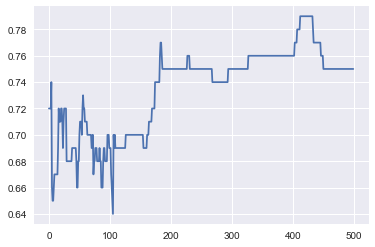

In [28]:
plt.plot(x_plot)
plt.show()

<h2> Question 19 </h2>

In [29]:
print("max accuracy is:")
print(max_accuracy)
print("best lambda is:")
print(max_lambda)

max accuracy is:
0.79
best lambda is:
4.12


<h2> Question 20 </h2>


Heat Map - Reward Function 2


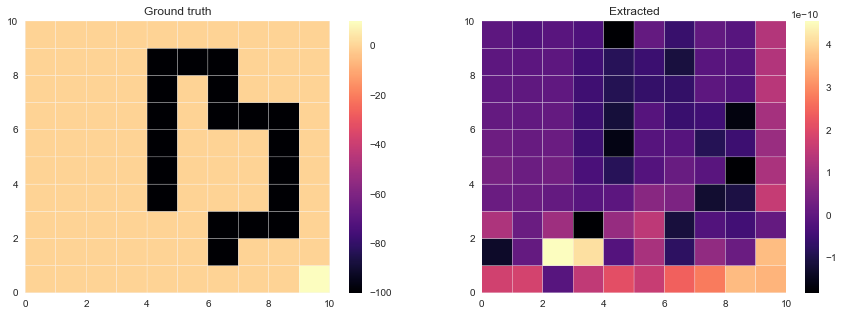

In [30]:

Rmax=1

# x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, 0.09)
# current_reward=x['x'][:state_num]
# current_reward=np.reshape(current_reward,(10,10))
# current_reward=np.transpose(current_reward)
# print(sns.heatmap(reward_1))
# print(sns.heatmap(current_reward))


print("\nHeat Map - Reward Function 2")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(reward_2), edgecolors = 'white', cmap = 'magma')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
plt.pcolor(np.flipud(max_reward), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()




<h2> Question 21 </h2>

Heat map of Optimal State Values for Reward Function 2


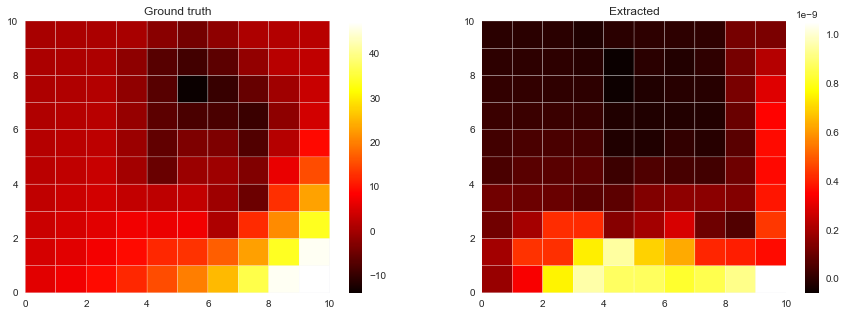

In [31]:
actual_value = value_iteration_value(reward_2, state_space, action_set, discount)
policy_value = value_iteration_value(max_reward, state_space, action_set, discount)

print("Heat map of Optimal State Values for Reward Function 2")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(actual_value), edgecolors = 'white', cmap = 'hot')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
#optimal_state_values_extracted_r1 = get_optimal_state_value_fn(extracted_reward_fn_1, S, A, gamma, 0.01, state_space, w)
plt.pcolor(np.flipud(policy_value), edgecolors = 'white', cmap = 'hot')
plt.colorbar()
plt.show()




<h2> Question 23 </h2>

In [32]:
print("Optimal policy - Ground truth vs Extracted - Reward Function 2")

arrows = [u'\u2191', u'\u2190',u'\u2193',u'\u2192']
arrow_matrix = np.array(policy_computed, dtype=object)
# print arrows
for i in range(0, 10):
    for j in range(0, 10):
        index = int(policy_computed[i][j])
        arrow_matrix[i][j] = arrows[index]

        

arrow1_matrix = np.array(actual_policy, dtype=object)
# print arrows
for i in range(0, 10):
    for j in range(0, 10):
        index = int(actual_policy[i][j])
        arrow1_matrix[i][j] = arrows[index]
        

multi_table([pd.DataFrame(arrow1_matrix), pd.DataFrame(arrow_matrix)])



Optimal policy - Ground truth vs Extracted - Reward Function 2


,0,1,2,3,4,5,6,7,8,9
0,↓,↓,↓,←,←,→,→,→,→,↓
1,↓,↓,↓,←,←,↑,→,→,→,↓
2,↓,↓,↓,←,←,↓,→,→,→,↓
3,↓,↓,↓,←,←,↓,↓,↑,→,↓
4,↓,↓,↓,←,←,↓,↓,↓,→,↓
5,↓,↓,↓,←,←,↓,↓,←,→,↓
6,↓,↓,↓,↓,↓,↓,←,←,→,↓
7,↓,↓,↓,↓,↓,↓,←,↓,↓,↓
8,→,→,→,↓,↓,↓,↓,↓,↓,↓
9,→,→,→,→,→,→,→,→,→,→


In [ ]:
count =0;
for i in range(10):
    for j in range(10):
        if(policy_computed[i][j]==actual_policy[i][j]):
            count+=1;
accuracy=count/100.0;
print(accuracy)

In [ ]:
ax1 = sns.heatmap(max_reward, annot=True)
plt.show()
print (max_reward)